In [1]:
import os
import requests

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# tf.enable_eager_execution()
np.random.seed(42)  # reproducibility

# Set so that Tensorflow can pull from the PRP S3/CEPH storage cluster
os.environ["S3_ENDPOINT"] = "s3.nautilus.optiputer.net"

# Simple syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") is "True" else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

DEBUG: OFF


In [2]:
# Load metadata about the dataset
metadata = requests.get("https://s3.nautilus.optiputer.net/braingeneers/simulated/metadata.json").json()
metadata.keys()

dict_keys(['test_examples_name', 'num_train_examples', 'image_height', 'num_test_examples', 'data_set', 'description', 'train_examples_name', 'image_width', 'labels'])

In [3]:
# Load trained model from S3

r = requests.get("https://s3.nautilus.optiputer.net/braingeneers/{}/{}/models/model.h5".format(
    os.environ["USER"], metadata["data_set"]))

import tempfile
temp_path = "/tmp/{}.h5".format(next(tempfile._get_candidate_names()))
open(temp_path, "wb").write(r.content)

model = tf.keras.models.load_model(temp_path)
os.remove(temp_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 87, 115, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 85, 113, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 150528)            602112    
_________________________________________________________________
output (Dense)               (None, 49)                7375921   
Total para

In [4]:
batch_size = 128

def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    
    # Extract the png from the example and convert to numpy
    image = tf.image.decode_png(example["example"], channels=1)
    
    # Optionally resize the image to reduce the size of the neural network
    image = tf.image.resize_images(
        image, [metadata["image_height"] // 4, metadata["image_width"] // 4])
    image = tf.image.per_image_standardization(image)
    
    # One hot encode our label
    label = tf.one_hot(example["label"], len(metadata["labels"]))
    
    return image, label

def create_dataset(files, batch_size, num_classes):
    # Create a data pipeline with shuffling and parallel loading
    # See https://www.tensorflow.org/guide/performance/datasets
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(parse_one_example, num_parallel_calls=8)
    dataset.cache("tensorflow.cache")
    # DON'T shuffle so this notebook is reproducible
#     dataset = dataset.shuffle(8 * num_classes)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

training_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["train_examples_name"])],
    batch_size, len(metadata["labels"]))
test_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["test_examples_name"])],
    batch_size, len(metadata["labels"]))

In [5]:
# Extract a batch of test samples and predict the first one
with tf.Session() as sess:
    examples, labels = sess.run(test_dataset.make_one_shot_iterator().get_next())

In [6]:
predictions = model.predict(examples, steps=1)
print("Example 0 Label: {} Prediction: {}".format(np.argmax(labels[0]), np.argmax(predictions[0])))

Example 0 Label: 12 Prediction: 12


In [7]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [8]:
# Use the entire batch as background to compute the SHAP values
explainer = shap.DeepExplainer(model, debug(examples[1:1+8], examples[1:64]))

# # plot the feature attributions - this will generate a tiny 1 x 49 display
# shap.image_plot(shap_values, -examples[0:1])

In [9]:
%%time
# Compute SHAP values for a single example
shap_values = explainer.shap_values(examples[0:1])

CPU times: user 17min 50s, sys: 44min 11s, total: 1h 2min 2s
Wall time: 8min 21s


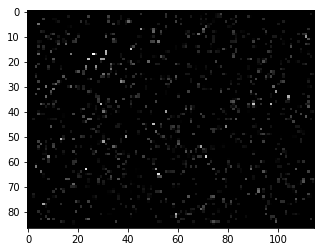

In [10]:
height = examples.shape[1]
width = examples.shape[2]
x = examples[0:1][0].reshape(height, width)

plt.imshow(x, cmap="gray")

In [11]:
from matplotlib.colors import LinearSegmentedColormap

colors = []
for l in np.linspace(1, 0, 100):
    colors.append((30./255, 136./255, 229./255,l))
for l in np.linspace(0, 1, 100):
    colors.append((255./255, 13./255, 87./255,l))
red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

In [12]:
abs_vals = np.stack([np.abs(shap_values[0].sum(-1)) for i in range(len(shap_values))], 0).flatten()
max_val = np.nanpercentile(abs_vals, 99.9)

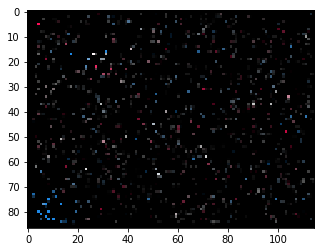

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1)

sv = shap_values[0][0].sum(-1)
axes.imshow(x, cmap="gray")
axes.imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)

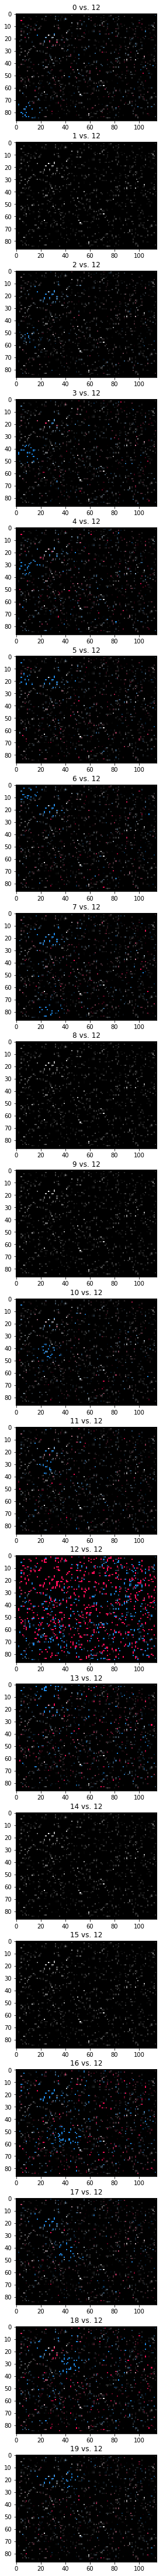

In [14]:
fig, axes = plt.subplots(nrows=20, ncols=1, figsize=[10, 80])

for i in range(20):
    sv = shap_values[i][0].sum(-1)
    axes[i].set_title("{} vs. {}".format(i, np.argmax(labels[0])))
    axes[i].imshow(x, cmap="gray")
    axes[i].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)